# Trivial test of Boltzman generator functionality

In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
import sys
sys.path.insert(0,'..')

from boltzmann_generator import BoltzmannGenerator
from energy_models.normal_distribution import NormalDistribution

### Create simple BG
- Create BG with just one RealNVP block and plot its topology.
- It will be trained to sample 10-dimensional vectors from isotropic normal distribution.
- Note that topology is quite compliated even in this simple case.

In [3]:
dim = 10
sigma = 10

In [4]:
normal_distribution_model = NormalDistribution(dim, sigma)
bg = BoltzmannGenerator(
    layers='R', 
    energy_model=normal_distribution_model,
)

Layers of invertible NN: <R>
< 10 0 0
R 5 5 0
> 5 5 0


In [5]:
bg.FzxJ.summary()

Model: "FzxJ"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
index_layer_3 (IndexLayer)      (None, 5)            0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 100)          600         index_layer_3[0][0]              
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          600         index_layer_3[0][0]              
_______________________________________________________________________________________________

## Train BG to produce gaussian distribution
### Test training by example
- Training set consists of 50 000 random samples from 10-dimensional isotropic normal distribution 

In [ ]:
size_of_training_set = 50000
x_training_set = np.random.normal(0.0, sigma, size=(size_of_training_set, dim))
print("Mean:", np.mean(x_training_set), "St. dev.: ", np.std(x_training_set))

Mean: -0.012662678074903 St. dev.:  9.975251125338188
Iteration 0/150: loss: 511.94 ML_loss: 511.94 
Iteration 10/150: loss: 477.75 ML_loss: 477.75 
Iteration 20/150: loss: 435.72 ML_loss: 435.72 
Iteration 30/150: loss: 417.21 ML_loss: 417.21 
Iteration 40/150: loss: 379.69 ML_loss: 379.69 
Iteration 50/150: loss: 344.97 ML_loss: 344.97 
Iteration 60/150: loss: 300.75 ML_loss: 300.75 
Iteration 70/150: loss: 244.24 ML_loss: 244.24 
Iteration 80/150: loss: 163.58 ML_loss: 163.58 
Iteration 90/150: loss: 110.03 ML_loss: 110.03 
Iteration 100/150: loss: 76.85 ML_loss: 76.85 
Iteration 110/150: loss: 52.79 ML_loss: 52.79 
Iteration 120/150: loss: 41.25 ML_loss: 41.25 
Iteration 130/150: loss: 36.74 ML_loss: 36.74 
Iteration 140/150: loss: 35.34 ML_loss: 35.34 


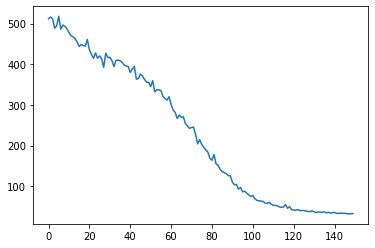

In [6]:
loss_vals_1 = bg.train(x_training_set, weight_ML=1, weight_KL=0, iterations=150, batch_size=500)
plt.plot(loss_vals_1["loss"])

Iteration 0/200: loss: 18.98 ML_loss: 32.26 KL_loss: -13.28 
Iteration 10/200: loss: 13.65 ML_loss: 30.05 KL_loss: -16.40 
Iteration 20/200: loss: 12.86 ML_loss: 29.57 KL_loss: -16.71 
Iteration 30/200: loss: 12.15 ML_loss: 29.20 KL_loss: -17.04 
Iteration 40/200: loss: 12.17 ML_loss: 29.13 KL_loss: -16.96 
Iteration 50/200: loss: 11.66 ML_loss: 28.77 KL_loss: -17.11 
Iteration 60/200: loss: 11.51 ML_loss: 28.71 KL_loss: -17.20 
Iteration 70/200: loss: 11.86 ML_loss: 29.06 KL_loss: -17.20 
Iteration 80/200: loss: 11.62 ML_loss: 28.91 KL_loss: -17.28 
Iteration 90/200: loss: 11.39 ML_loss: 28.75 KL_loss: -17.36 
Iteration 100/200: loss: 11.83 ML_loss: 28.99 KL_loss: -17.16 
Iteration 110/200: loss: 10.99 ML_loss: 28.51 KL_loss: -17.52 
Iteration 120/200: loss: 11.39 ML_loss: 28.82 KL_loss: -17.43 
Iteration 130/200: loss: 11.20 ML_loss: 28.53 KL_loss: -17.33 
Iteration 140/200: loss: 11.47 ML_loss: 28.64 KL_loss: -17.18 
Iteration 150/200: loss: 11.18 ML_loss: 28.61 KL_loss: -17.43 
Ite

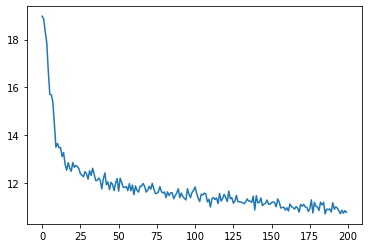

In [7]:
loss_vals_2 = bg.train(x_training_set, weight_ML=1, weight_KL=1, iterations=200, batch_size=1000, verbose=True)
plt.plot(loss_vals_2["loss"])

## Evaluate quality of BG as sampler

In [8]:
n_samples = 100000
sample = bg.sample(n_samples)[1]
coordinate = np.random.choice(np.arange(dim))
print("Chosen coordinate:", coordinate)
x = sample[:,coordinate]
print("Mean:", np.mean(x), "St. dev.:", np.std(x))

Chosen coordinate: 8
Mean: -0.012360304 St. dev.: 10.212243


Fit properties: 
Mean: 0.013262881072111115 
Amplitude: 2317.268561816333 
Standard deviation: 10.191847824932168


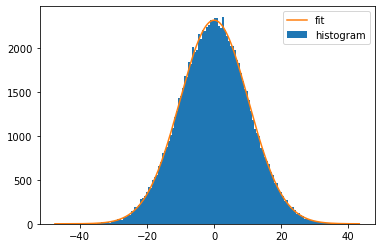

In [9]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / ( 2 * standard_deviation**2))

bin_heights, bin_borders, _ = plt.hist(x, bins='auto', label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()
print("Fit properties:", "\nMean:", popt[0], "\nAmplitude:", popt[1], "\nStandard deviation:", popt[2])